In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
movies_TFIDF = pd.read_csv('3a movies_TFIDF.csv')
movies_GloVe = pd.read_csv('3b movies_GloVe.csv')
country_codes = pd.read_csv('country_codes.csv')

In [3]:
## Drop the remaining NaN values
# movies_TFIDF.dropna(inplace = True)
# movies_TFIDF.to_csv('3a movies_TFIDF.csv', index=False)
# movies_GloVe.dropna(inplace = True)
# movies_GloVe.to_csv('3b movies_GloVe.csv', index=False)

In [4]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    movies = movies.drop(['id', 'title'], axis=1)
    
    # Categorical values are not used, because of the algorithm
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric)
    
    return movievectors

In [5]:
movies_TFIDF = prepare_dataframe(movies_TFIDF)
movies_GloVe = prepare_dataframe(movies_GloVe)

Use silhouette score for test purposes:

In [6]:
# 1. test: TF-IDF vs GloVe model and measure runtime
df1 = pd.DataFrame(columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
for i in range(5, 51, 5):
    
    # K-Means
    start1 = time.time()
    kmeans_TFIDF = KMeans(n_clusters=i)
    kmeans_TFIDF.fit(movies_TFIDF)
    end1 = time.time()
    
    start2 = time.time()
    kmeans_GloVe = KMeans(n_clusters=i)
    kmeans_GloVe.fit(movies_GloVe)
    end2 = time.time()
    
    tfscore = silhouette_score(movies_TFIDF, kmeans_TFIDF.predict(movies_TFIDF))
    elapsed1 = end1-start1
    
    emscore = silhouette_score(movies_GloVe, kmeans_GloVe.predict(movies_GloVe))
    elapsed2 = end2-start2
    
    scores = pd.DataFrame([[i, tfscore, elapsed1, emscore, elapsed2]],
                          columns=['Number of clusters', 'TF-IDF', 'TF-IDF runtime',
                                   'GloVe model', 'GloVe model runtime'])
    df1 = pd.concat([df1, scores], axis=0)

In [7]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of clusters', ylabel='Silhouette Score'>

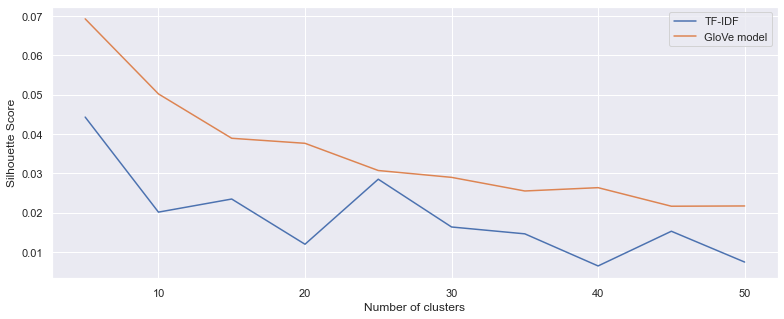

In [8]:
# Visualize the results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF', label='TF-IDF')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model', label='GloVe model')

<AxesSubplot:xlabel='Number of clusters', ylabel='Runtime in seconds'>

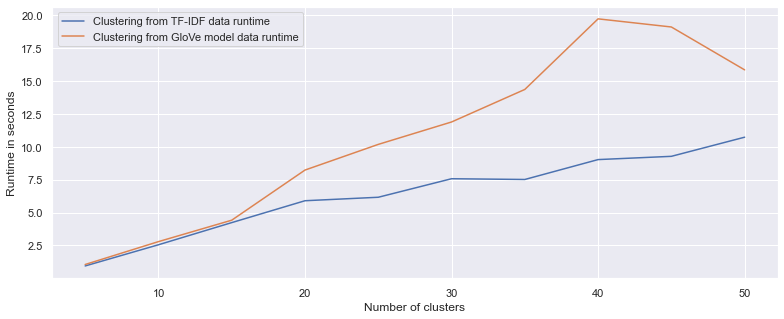

In [9]:
# Visualize the runtime results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))
plt.ylabel('Runtime in seconds')

sns.lineplot(data = df1, x='Number of clusters', y='TF-IDF runtime', label='Clustering from TF-IDF data runtime')
sns.lineplot(data = df1, x='Number of clusters', y='GloVe model runtime',
             label='Clustering from GloVe model data runtime')

In [10]:
# 2. test: PCA on TF-IDF solution 35 clusters
df1 = pd.DataFrame(columns=['Number of dimensions','Silhouette score', 'Runtime'])
clusters = 35
for dimensions in range(movies_TFIDF.shape[1], 2, -2):
    
    pca = PCA(n_components=dimensions)
    reduced_data = pca.fit_transform(movies_TFIDF)
    
    # K-Means
    start1 = time.time()
    kmeans_TFIDF = KMeans(n_clusters=clusters)
    kmeans_TFIDF.fit(reduced_data)
    end1 = time.time()
    
    tfscore = silhouette_score(reduced_data, kmeans_TFIDF.predict(reduced_data))
    elapsed1 = end1-start1
    
    scores = pd.DataFrame([[dimensions, tfscore, elapsed1]],
                          columns=['Number of dimensions','Silhouette score', 'Runtime'])
    df1 = pd.concat([df1, scores], axis=0)

In [11]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of dimensions', ylabel='Silhouette score'>

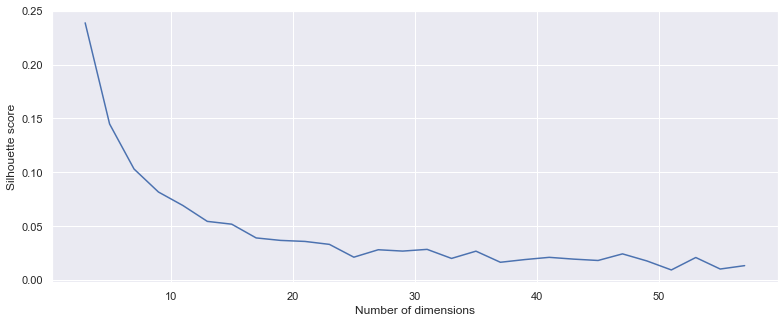

In [12]:
# Visualize the results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))

sns.lineplot(data = df1, x='Number of dimensions', y='Silhouette score')

<AxesSubplot:xlabel='Number of dimensions', ylabel='Runtime'>

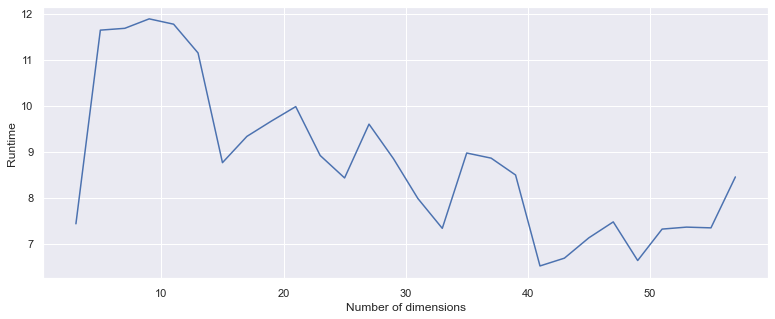

In [13]:
# Visualize the results
sns.set_theme(style="darkgrid")
plt.figure(figsize=(13,5))

sns.lineplot(data = df1, x='Number of dimensions', y='Runtime')